### Get session info
- Data is appended per cell


In [1]:
# dataPath = '/Volumes/genie/Jihong_GENIE_stuff/Voltron-ST&Kv2.1/'
date = '190128'
dataPath = '/Users/zhengj10/Desktop/Ahmed'


### Import modules

In [2]:
import os
from glob import glob
from pywavesurfer import ws
from WC_ephys_Voltron import get_data, mem_test, get_rmp, get_threshold, get_AP_params, low_pass
import numpy as np
import scipy.signal as ss
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from termcolor import colored
import unicodedata
import pandas as pd


In [3]:
cellPath = os.path.join(dataPath, date)
print(os.path.exists(cellPath))


True


### Locate data files

In [4]:
cells = [d for d in os.listdir(cellPath) if os.path.isdir(os.path.join(cellPath, d))]
cells = sorted(cells)
cells
# h5files = glob(os.path.join(dataPath, '*.h5'))
# h5files = sorted(h5files)
# h5files


['cell_1', 'cell_2', 'cell_3', 'cell_4', 'cell_5']

### Load h5 data

In [5]:
cell = 'cell_1'
h5files = glob(os.path.join(dataPath, date, cell, '*.h5'))
h5files = sorted(h5files)
h5files


['/Users/zhengj10/Desktop/Ahmed/190128/cell_1/trial_0001-0010.h5',
 '/Users/zhengj10/Desktop/Ahmed/190128/cell_1/trial_0011.h5',
 '/Users/zhengj10/Desktop/Ahmed/190128/cell_1/trial_0012.h5',
 '/Users/zhengj10/Desktop/Ahmed/190128/cell_1/trial_0013.h5',
 '/Users/zhengj10/Desktop/Ahmed/190128/cell_1/trial_0014.h5']

In [6]:
plt.figure(figsize=(10,4))
traces, meta = get_data(h5files[0])
trace = traces[4]
trace_lpfilt = low_pass(trace)
trace_med = ss.medfilt(trace, kernel_size = 5)
ax1 = plt.subplot(1,3,1)
ax1.plot(trace)
ax2 = plt.subplot(1,3,2)
ax2.plot(trace_lpfilt)
ax3 = plt.subplot(1,3,3)
ax3.plot(trace_med)
plt.show()


KeyError: 'Delay'

<Figure size 720x288 with 0 Axes>

In [22]:
data_as_dict = ws.loadDataFile(filename=h5files[0])

In [23]:
sortedKeys = sorted(data_as_dict.keys())
sweeps = sortedKeys[1:]
traces = []
for sweep in sweeps:
    trace = data_as_dict[sweep]['analogScans'][0]
    traces.append(trace)

In [25]:
len(traces)

10

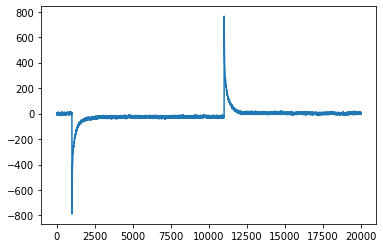

In [28]:
plt.plot(traces[1])
plt.show()

In [31]:
data_as_dict['header']['StimulusLibrary']['Stimuli']

{'element1': {'AdditionalParameterDisplayNames': array([b'Delay', b'Duration', b'Amplitude', b'DC Offset'], dtype='|S9'),
  'AdditionalParameterDisplayUnitses': array([b's', b's', b'', b''], dtype='|S1'),
  'AdditionalParameterNames': array([b'Delay', b'Duration', b'Amplitude', b'DCOffset'], dtype='|S9'),
  'Delegate': {'Amplitude': array([b'5'], dtype='|S1'),
   'DCOffset': array([b'0'], dtype='|S1'),
   'Delay': array([b'0'], dtype='|S1'),
   'Duration': array([b'3'], dtype='|S1'),
   'EndTime': array([[3.]]),
   'TypeString': array([b'SquarePulse'], dtype='|S11')},
  'EndTime': array([[3.]]),
  'Name': array([b'EXT_LEVEL_500mV3s'], dtype='|S17'),
  'TypeString': array([b'SquarePulse'], dtype='|S11')},
 'element2': {'AdditionalParameterDisplayNames': array([b'Delay', b'Duration', b'Amplitude', b'DC Offset', b'Period',
         b'Pulse Duration'], dtype='|S14'),
  'AdditionalParameterDisplayUnitses': array([b's', b's', b'', b'', b's', b's'], dtype='|S1'),
  'AdditionalParameterNames':

In [ ]:
# from scipy import signal

# def low_pass(trace, cut = 0.125):
#     b, a = signal.butter(8, 0.06)
#     y = signal.filtfilt(b, a, trace, padlen=150)
#     return y

# y = low_pass(trace)
# print y.shape
# plt.plot(y)
# plt.show()


In [ ]:
# def mov_mean(trace, stride = 100):
#     trace_filt = np.zeros(trace.shape[0])
#     for point in range(trace.shape[0]):
#         trace_filt[point] = np.mean(trace[point:point+stride])
#     return trace_filt


In [ ]:
for h5data in h5files:
    traces, meta = get_data(h5data)
    print meta['trialType']
    if meta['trialType'] == 'VC_10mV_100ms_0.3s':
        Ra, Rm, Cm, tau, seal_quality = mem_test(h5data, Vstep = 10.0, height = 200)
        traces, meta = get_data(h5data)
        trace = np.mean(traces, axis=0)
        x = (np.arange(1, trace.shape[0]+1))*1000.0/meta['sampleRate']
        plt.plot(x, trace, color = 'b', lw = 0.8)
        plt.ylabel('pA', size = 15)
        plt.show()
        print 'Ra: %s; Rm: %s; Cm: %s, tau: %s' %(Ra, Rm, Cm, tau)
        print 'Seal quality: %s' %(seal_quality)
        print colored('Ra: ', attrs=['bold']) + str(round(Ra, 2)) + ' M' + unicodedata.lookup("GREEK CAPITAL LETTER omega")
        print colored('Rm: ', attrs=['bold']) + str(round(Rm, 2)) + ' M' + unicodedata.lookup("GREEK CAPITAL LETTER omega")
        print colored('Cm: ', attrs=['bold']) + str(round(Cm, 2)) + ' pF'
        print colored('Sq: ', attrs=['bold']) + str(seal_quality)
        break


### Parameters visualization

In [ ]:
rate = 20
tail = 0.02


In [ ]:
fig = plt.figure(figsize=(8,20))
for h5data in h5files:
    traces, meta = get_data(h5data)
    if meta['trialType'] == 'current_ramp':
        all_trials = {}
        for traceNum in range(len(traces)):
#         for traceNum in range(4):
#         for traceNum in (0,1,7):
            print traceNum
            trace = traces[traceNum]
            if np.max(trace) < 0: ## Skip trials without spike or too much noise
                continue
#             trace = ss.medfilt(trace, kernel_size=3) ## Median filter
#             trace = mov_mean(trace, stride = 100)
            time, Ith, Vth = get_threshold(h5data, traceNum = traceNum, rate = rate, filt = False, cut = 0.125)
            ax = fig.add_subplot(len(traces), 2, traceNum*2+1)
#             ax = fig.add_subplot(1, 2, 1)
            ax.plot(trace, lw = 0.8, color = 'g')
            ax.scatter(time, Vth, color = 'm', s = 20)
            ax.set_ylabel(traceNum+1)
            preSpike = int(0.01*meta['sampleRate'])
            postSpike = int(0.02*meta['sampleRate'])
            ax = fig.add_subplot(len(traces), 2, traceNum*2+2)
#             ax = fig.add_subplot(1, 2, 2)
            AP_info = get_AP_params(h5data, height = 0, traceNum = traceNum, rate = rate, tail = tail, filt = False, cut = 0.125)
            ax.plot(AP_info['trace_for_AP'], color = 'g')
            ax.scatter(AP_info['pre_threshold_seg'] , AP_info['trace_for_AP'][AP_info['pre_threshold_seg']], color = 'm', s = 50)
            ax.hlines(AP_info['peak_value'], xmin = 50, xmax = int(0.014*meta['sampleRate']), linestyle = '--',)
            a = int(0.01*meta['sampleRate'])
            AP_hw_xmin = AP_info['pre_threshold_seg'] + AP_info['AP_halfWidth'][2][0]
            AP_hw_xmax = AP_info['pre_threshold_seg'] + AP_info['AP_halfWidth'][3][0]
            ax.hlines(AP_info['AP_halfWidth'][1][0], xmin=AP_hw_xmin, xmax=AP_hw_xmax, linestyle = '--', )
            ax.hlines(AP_info['trace_for_AP'][AP_info['pre_threshold_seg']], xmin = 50, xmax = int(0.014*meta['sampleRate']), linestyle = '--')
            ax.hlines(AP_info['RMP'], xmin = 0, xmax = 600, linestyle = '--')
            ax.hlines(AP_info['half_AHP_amp'], xmin = AP_info['hfAHP_start'], xmax = AP_info['hfAHP_end'], linestyle = '--')
            all_trials[traceNum+1] = AP_info
        break
plt.show()


### Select trial and output data (criteria followed)
- First trial evoked 2 or more spikes
- Threshold point, AP and AHP measurement in the right places.

In [ ]:
trial_selected = 2
AP_info = all_trials[trial_selected]
remark = ''


In [ ]:
sessionInfo = {
                u'Date': date,
                u'Cell': cell,
                u'Ra': Ra,
                u'Rm': Rm,
                u'Cm': Cm,
                u'tau': tau,
                u'RMP': AP_info['RMP'],
                u'Ith': Ith,
                u'Vth': Vth,
                u'AP_amplitude': AP_info['AP_amplitude'],
                u'AP_width': AP_info['AP_halfWidth'][0][0] * 1000.0 / meta['sampleRate'],
                u'uIth': Ith/Cm,
                u'trial_selected(CC)': trial_selected,
                u'Remark': remark
            }


In [ ]:
sumFile = os.path.join(dataPath, 'summary_Ahmed_data.xlsx')
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_colwidth', 8)
df = pd.read_excel(sumFile, index_col = 0)


In [ ]:
df_new = pd.DataFrame(sessionInfo, columns = list(df), index = ['i',]) # columns specification keeps the order of columns; index specification makes sure dict keys are the columns 
df = df.append(df_new, ignore_index = True)
df.index = np.arange(1, len(df)+1)
df.to_excel(sumFile)
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_colwidth', 8)
df


In [ ]:
# idx = len(df)
# df = df.drop(idx)
# df.to_excel(dataPath + '/summary_Ahmed_data.xlsx')
# df
